In [1]:
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
sentences = []
labels = []

with open("../input/sms-spam-collection-dataset/spam.csv",encoding="ISO-8859-1") as csvfile:
    spamreader = csv.reader(csvfile)
    next(spamreader)
    for row in spamreader:
        if row[0] == "ham":
            labels.append(0)
        else:
            labels.append(1)
        sentences.append(row[1])
        
print(len(sentences))
print(len(labels))

total_len = len(sentences)

5572
5572


In [3]:
split = int(total_len*0.9)

training_sentences = sentences[:split]
testing_sentences = sentences[split:]
training_labels = labels[:split]
testing_labels = labels[split:]

In [4]:
vocab_size = 200
oov_tok = "<OOV>"
embedding_dim = 16

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences)

max_sequence_len = max([len(x) for x in sequences])

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_sequence_len)

In [5]:
training_padded = np.array(padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

print(training_padded.shape)
print(training_labels.shape)
print(testing_padded.shape)
print(testing_labels.shape)

(5014, 189)
(5014,)
(558, 189)
(558,)


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 16)           3200      
_________________________________________________________________
bidirectional (Bidirectional (None, 189, 64)           12544     
_________________________________________________________________
conv1d (Conv1D)              (None, 185, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 46, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2944)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2944)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                7

In [7]:
class myCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") >= 0.99:
            print("Reached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCb()

In [8]:
num_epochs = 20
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[callbacks],
                    verbose=1)

Epoch 1/20


2021-11-20 18:54:01.571223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


157/157 [==============================] - 37s 206ms/step - loss: 0.2026 - accuracy: 0.9210 - val_loss: 0.1151 - val_accuracy: 0.9857
Epoch 2/20
157/157 [==============================] - 31s 199ms/step - loss: 0.1235 - accuracy: 0.9737 - val_loss: 0.0990 - val_accuracy: 0.9857
Epoch 3/20
157/157 [==============================] - 31s 196ms/step - loss: 0.1047 - accuracy: 0.9757 - val_loss: 0.0833 - val_accuracy: 0.9857
Epoch 4/20
157/157 [==============================] - 31s 200ms/step - loss: 0.0806 - accuracy: 0.9789 - val_loss: 0.0778 - val_accuracy: 0.9839
Epoch 5/20
157/157 [==============================] - 31s 200ms/step - loss: 0.0727 - accuracy: 0.9828 - val_loss: 0.0818 - val_accuracy: 0.9857
Epoch 6/20
157/157 [==============================] - 32s 205ms/step - loss: 0.0598 - accuracy: 0.9840 - val_loss: 0.1266 - val_accuracy: 0.9821
Epoch 7/20
157/157 [==============================] - 32s 202ms/step - loss: 0.0599 - accuracy: 0.9838 - val_loss: 0.1033 - val_accuracy: 0.9

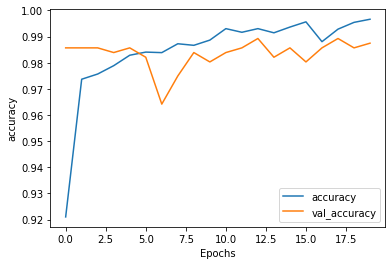

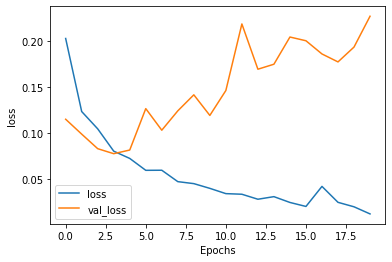

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')